In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import matplotlib.pyplot as plt

import time

In [5]:
# torch.manual_seed(42)

In [2]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device = 'cpu'

print(f'device: {device}')

device: cpu


In [3]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.layers = layers
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.H1 = self.linears[0]

        
    'forward pass'
    def forward(self,x,y):              
        
        # for i in range(len(self.layers)-2):
        #     z = self.linears[i](a)
        #     a = self.activation(z)

        a = torch.cat([x,y], dim = 1)    #(N,2)

        for i in range(len(self.layers)-2):
            m = self.linears[i](a)
            a = self.activation(m)


            
        b = self.linears[-1](a) 
         
        return b
    
    # def forward_direct(self, x,y,t,keep=("x","y","t")):
    def forward_direct(self,x,y):
        
        z = torch.cat([x,y], dim = 1)    #(N,2)  

        # dic = {"x":0, "y":1, "t":2}  
        # idx = [dic[k] for k in keep]

        N = z.shape[0]   


        # W1 = self.linears[0].weight    # (20,3)

        # H = W1[:, idx].unsqueeze(0)      # (1,20,3)
        # F = torch.zeros_like(H)          # (1,20,3)

        W1 = self.linears[0].weight    # (20,2)

        H = W1[:, [0,1]].unsqueeze(0).expand(N, -1, -1)                                   # (N,20,2)
        F = torch.zeros(N, W1.shape[0], 2, device=z.device, dtype=z.dtype)                  # (N,20,2)     



        

        for i in range(len(self.layers)-2):
            L = self.linears[i](z)            # (N,20)
            z = self.activation(L)            # (N,20)

            z_1 = 1.0-torch.square(z)         # (N,20)
            z_2 = -2*z + 2*torch.pow(z,3)     # (N,20)

            z_1 = z_1.unsqueeze(-1)           # (N,20,1)
            z_2 = z_2.unsqueeze(-1)           # (N,20,1)

            # if H.shape[0] == 1:
            #     H = H.expand(N, -1, -1)                    # (N,20,3)
            #     F = F.expand(N, -1, -1)                    # (N,20,3)

            G = z_1*H    #\sigma'(L)*H   # (N,20,2)

            # H_xy = H[..., :2]                        # (N,20,2)
            
 
            C = z_2*H*H                # (N,20,2)


            E = C + z_1*F                # (N,20,2)

            W_next = self.linears[i+1].weight.t()       # (20,20)

            H = torch.einsum('nhk,hp->npk', G, W_next)  # (N,20,2)
            F = torch.einsum('nhk,hp->npk', E, W_next)  # (N,20,2)


        z = self.linears[-1](z)                         # (N,1)
         
        # return z, H_x, H_y, H_t, F_x, F_y, F_t
        return z, H, F  

    # # TENSORIZED
    
    
    # def forward_direct(self, x,t):
        
    #     z = torch.cat([x,t], dim = 1)    #(N,2)      N = 90000
    #     N = z.size(0)

    #     W1 = self.linears[0].weight    # (20,2)

    #     H = W1.unsqueeze(0).expand(N,-1,-1).contiguous()     #(N,20,2)
    #     F = torch.zeros_like(H)

    #     # H_x = W1[:, 0].unsqueeze(0)      # (1,20)
    #     # F_x = torch.zeros_like(H_x)

    #     # H_t = W1[:, 1].unsqueeze(0)      # (1,20)
    #     # F_t = torch.zeros_like(H_t)
        

    #     for i in range(len(self.layers)-2):
    #         L = self.linears[i](z)            # (N,20)
    #         z = self.activation(L)            # (N,20)
    #         z_1 = 1.0-torch.square(z)         # (N,20)
    #         z_1 = z_1.unsqueeze(-1)           # (N,20,1)

    #         G = z_1*H     #\sigma'(L)*H   # (N,20,2)

    #         # G_x = z_1*H_x     #\sigma'(L)*H   # (N,20)
    #         # G_t = z_1*H_t                     # (N,20)

    #         z_2 = (-2*z + 2*torch.pow(z,3))   #(N,20)
    #         z_2 = z_2.unsqueeze(-1)           # (N,20,1)

    #         C = z_2*H*H                       # (N,20,2)




    #         # C_x = (-2*z + 2*torch.pow(z,3))*H_x*H_x
    #         # C_t = (-2*z + 2*torch.pow(z,3))*H_t*H_t

    #         E = C + z_1*F                     # (N,20,2)     

    #         # E_x = C_x + z_1*F_x    # (N,50)
    #         # E_t = C_t + z_1*F_t    # (N,50)

    #         H = torch.matmul(G.transpose(1, 2),self.linears[i+1].weight.t()).transpose(1, 2)     # (N,2,20) * (20,1)  = (N,2,1).t() = (N,1,2)
    #         F = torch.matmul(E.transpose(1, 2),self.linears[i+1].weight.t()).transpose(1, 2)     # (N,1,2)


    #         # H_x = torch.matmul(G_x,self.linears[i+1].weight.t())
    #         # F_x = torch.matmul(E_x,self.linears[i+1].weight.t())

    #         # H_t = torch.matmul(G_t,self.linears[i+1].weight.t())
    #         # F_t = torch.matmul(E_t,self.linears[i+1].weight.t())

    #     z = self.linears[-1](z)

    #     H_x = H[:, 0, 0].unsqueeze(-1)   # (N,1)
    #     H_t = H[:, 0, 1].unsqueeze(-1)   # (N,1)
    #     F_x = F[:, 0, 0].unsqueeze(-1)   # (N,1)
    #     F_t = F[:, 0, 1].unsqueeze(-1)   # (N,1)
         
    #     return z, H_x, H_t, F_x, F_t
    


In [4]:
# layers = np.array([2,50,50,50,50,50,1])
layers = np.array([2,20,20,20,20,20,1])
# PINN = Sequentialmodel(layers).to(device)

In [ ]:
# Resetting to ensure the reported peak truly reflects the training loop, rather than including earlier setup.

# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [32]:
# Create the training data

x = torch.linspace(0,1,600).view(-1,1)
y = torch.linspace(0,1,600).view(-1,1)



if torch.is_tensor(x) != True:         
    x = torch.from_numpy(x)  
if torch.is_tensor(y) != True:         
    y = torch.from_numpy(y) 


#convert to float
x = x.float()
y = y.float()


    
x_train,y_train = torch.meshgrid(x.squeeze(),y.squeeze(), indexing = 'xy')

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


x_train = x_train.reshape(-1,1)     
y_train = y_train.reshape(-1,1) 

     



In [33]:
# Create boundary points

def generate_boundary_points(N = 10000):
    x_0 = torch.zeros(N,1) ; x_1 = torch.ones(N,1); ylr = torch.linspace(0,1.,N).unsqueeze(-1)
    # b_l = torch.cat([x_0,ylr], dim = 1); b_r = torch.cat([x_1,ylr], dim = 1)

    y_0 = torch.zeros(N,1); y_1 = torch.ones(N,1); xbt = torch.linspace(0,1.,N).unsqueeze(-1)
    # b_b = torch.cat([xbt,y_0], dim = 1); b_t = torch.cat([xbt,y_1], dim = 1)

    # x_0 = x_0.to(device)
    # x_1 = x_1.to(device)
    # ylr = ylr.to(device)
    


    # y_0 = y_0.to(device)
    # y_1 = y_1.to(device)
    # xbt = xbt.to(device)

    return x_0, x_1, ylr, y_0, y_1, xbt

In [34]:
def pde_residual(x,y):
    u = PINN(x,y)

    # m, H_x, H_y, F_x, F_y = PINN.forward_direct(x,y,t)
    z,H,F = PINN.forward_direct(x,y)

    du_dx = H[..., 0]
    du_dy = H[..., 1]
    
    du_dx_x = F[..., 0]
    du_dy_y = F[..., 1]
    
    

    res_pde = du_dx_x + du_dy_y


    return res_pde

In [ ]:
def boundary_condition():

    x_0, x_1, ylr, y_0, y_1, xbt = generate_boundary_points()

    u_x_0 = PINN(x_0, ylr)
    u_x_1 = PINN(x_1, ylr)

    u_y_0 = PINN(xbt,y_0)
    u_y_1 = PINN(xbt,y_1)

   

    res_x_0 = u_x_0 - torch.zeros_like(ylr)
    res_x_1 = u_x_1 - torch.sin(np.pi * ylr)
    res_y_0 = u_y_0 - torch.zeros_like(xbt)
    res_y_1 = u_y_1 - torch.zeros_like(xbt)
    

    return res_x_0,res_x_1,res_y_0,res_y_1

In [ ]:
def compute_losses():
   res_pde = pde_residual(x_train, y_train) 
   
   res_x_0,res_x_1,res_y_0,res_y_1 = boundary_condition()

   loss_pde = torch.mean(res_pde**2)
   
   loss_bc = torch.mean(res_x_0**2) + torch.mean(res_x_1**2) + torch.mean(res_y_0**2) + torch.mean(res_y_1**2)

   total_loss = loss_pde + loss_bc

   return total_loss

In [ ]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [ ]:
# No. of epochs


# start_time = time.time()

# num_epochs = 10000



# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()

#     if (epoch) % 200 == 0:
#      print(f'Epoch {epoch}, Loss: {total_loss.item()}')


# end_time = time.time()

# print(f'Total Training Time: {(end_time - start_time): .4f}seconds')


    








In [39]:
torch.manual_seed(42)
# PINN = Sequentialmodel(layers).to(device)
PINN = Sequentialmodel(layers)

In [ ]:
# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [ ]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [ ]:
# # Threshold loss as the stopping criteria

# max_epochs = 15000
# threshold = 0.002



# start_time = time.time()

# ep = 0
# while ep < max_epochs:
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()


#     if total_loss.item() < threshold:
#         print(f"Reached threshold loss {threshold} at epoch {ep}")
#         break

#     if (ep) % 200 == 0:
#      print(f'Epoch {ep}, Loss: {total_loss.item()}')

#     ep += 1


# print(f"Training stopped at epoch {ep}, total time {time.time() - start_time:.2f} s")





In [40]:
# Using LBFGS

optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,max_iter=20,history_size=50,tolerance_grad=1e-9,tolerance_change=1e-9,line_search_fn='strong_wolfe')

max_outer_steps = 15000
threshold = 0.002

start_time = time.time()
ep = 0


def closure():

    optimizer.zero_grad()
    total_loss = compute_losses()
    total_loss.backward()

    return total_loss

while ep < max_outer_steps:

    total_loss = optimizer.step(closure)

    if total_loss.item() < threshold:
        print(f"Reached threshold loss {threshold} at outer step {ep}")
        break

    if ep % 200 == 0:
        print(f'Outer {ep}, Loss: {total_loss.item()}')

    ep += 1

print(f"Training stopped at outer step {ep}, total time {time.time() - start_time:.2f} s")
    

Outer 0, Loss: 0.8004339933395386
Reached threshold loss 0.002 at outer step 25
Training stopped at outer step 25, total time 395.39 s


In [ ]:
# # Memory usage after training

# if device.type == 'cuda':
#     peak_mem = torch.cuda.max_memory_allocated(device)
#     print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

In [25]:
import math

def u_closed_form(x, y):
    pi = torch.tensor(math.pi)
    d = torch.sinh(pi)
    sol = (torch.sinh(pi * x) / d) * torch.sin(torch.pi * y)
    return sol

In [26]:
x_test = torch.linspace(0,1,60).view(-1,1)
y_test = torch.linspace(0,1,60).view(-1,1)



# if torch.is_tensor(x_test) != True:         
#     x_test = torch.from_numpy(x_test)  
# if torch.is_tensor(y_test) != True:         
#     y_test = torch.from_numpy(y_test) 


# #convert to float
# x = x_test.float()
# y = y_test.float()


    
# x_test,y_test = torch.meshgrid(x.squeeze(),y.squeeze(), indexing = 'xy')
x_test,y_test = torch.meshgrid(x_test.squeeze(),y_test.squeeze(), indexing = 'xy')

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


x_test = x_test.reshape(-1,1)     
y_test = y_test.reshape(-1,1) 


u_true = u_closed_form(x_test, y_test) 


u_pred = PINN(x_test,y_test)

mse = torch.mean((u_pred - u_true)**2).item()
print(f"MSE vs closed-form: {mse:.3e}")

MSE vs closed-form: 7.626e-05


In [27]:
def compare(PINN):
    PINN.eval()


    x_test = torch.linspace(0,1,60).view(-1,1)
    y_test = torch.linspace(0,1,60).view(-1,1)



    # if torch.is_tensor(x_test) != True:  
    #     x_test = torch.from_numpy(x_test)
    # if torch.is_tensor(y_test) != True:  
    #     y_test = torch.from_numpy(y_test)   


    # #convert to float
    # x = x_test.float()
    # y = y_test.float()    
    

    
    x_test,y_test = torch.meshgrid(x_test.squeeze(),y_test.squeeze(), indexing = 'xy')

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


    x_test = x_test.reshape(-1,1)     
    y_test = y_test.reshape(-1,1) 


    u_true = u_closed_form(x_test, y_test).reshape(60,60) 


    u_pred = PINN(x_test,y_test)

    u_pred_np = u_pred.reshape(60,60).detach().cpu()


    fig, axs = plt.subplots(1, 2, figsize=(12, 3.6), constrained_layout=True)
    im0 = axs[0].imshow(u_true.cpu(), origin='lower', cmap = "jet", extent=[0,1,0,1])
    axs[0].set_title("Closed-form")
    axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(u_pred_np.cpu(), origin='lower', cmap = "jet", extent=[0,1,0,1])
    axs[1].set_title("PINN Prediction")
    axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); fig.colorbar(im1, ax=axs[1])


    # Saving the plot

    # plt.savefig('Closed-form_solution_vs_PINN_prediction.svg',format = 'svg',bbox_inches = 'tight')

    for ext in ["png", "pdf", "svg","eps"]:
      plt.savefig(f"Comparison_without_autograd.{ext}", bbox_inches='tight', dpi=300)

  

    plt.show()


  


   

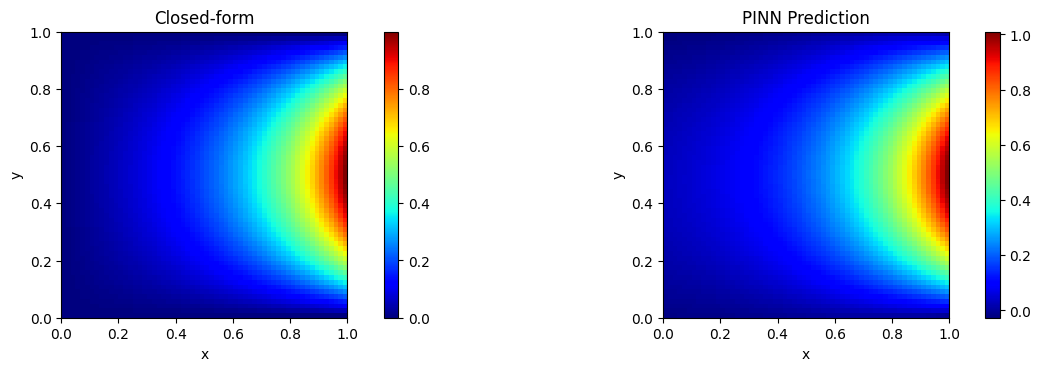

In [28]:
compare(PINN)

In [29]:
import math, torch
def u_closed_torch(x, y):
    pi = torch.tensor(math.pi, device=x.device, dtype=x.dtype)
    den = torch.sinh(pi)
    return torch.sinh(pi*x)/den * torch.sin(pi*y)

# tiny grid
xs = torch.linspace(0.,1.,5)
ys = torch.linspace(0.,1.,5)
X, Y = torch.meshgrid(xs, ys, indexing='ij')
U = u_closed_torch(X, Y)

print("u(0, 0.5) =", U[0, 2].item(), "  (expect ~0.000)")
print("u(1, 0.5) =", U[-1,2].item(), "  (expect ~1.000)")
print("var across x at y=0.5 =", U[:,2].var().item(), " (should be > 0)")

u(0, 0.5) = 0.0   (expect ~0.000)
u(1, 0.5) = 1.0   (expect ~1.000)
var across x at y=0.5 = 0.16341644525527954  (should be > 0)
